Tutorial: [Posterior Predictive Checks](https://docs.pymc.io/notebooks/posterior_predictive.html)

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as st
import seaborn as sns
import arviz as az
from theano import shared

plt.style.use('seaborn-whitegrid')
print('Running with PyMC3 version v.{}'.format(pm.__version__))

Running with PyMC3 version v.3.8


In [2]:
az.rcParams['stats.credible_interval'] = 0.89
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['legend.fontsize']=12
plt.rcParams['axes.labelsize']=12
plt.rcParams['axes.titlesize']=12
plt.rcParams['figure.titlesize']=15

In [29]:
data = np.random.randn(100)

with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=1, testval=0)
    sd = pm.HalfNormal('sd', sigma=1)
    n = pm.Normal('n', mu=mu, sigma=sd, observed=data)
    
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:04<00:00, 4469.64draws/s]


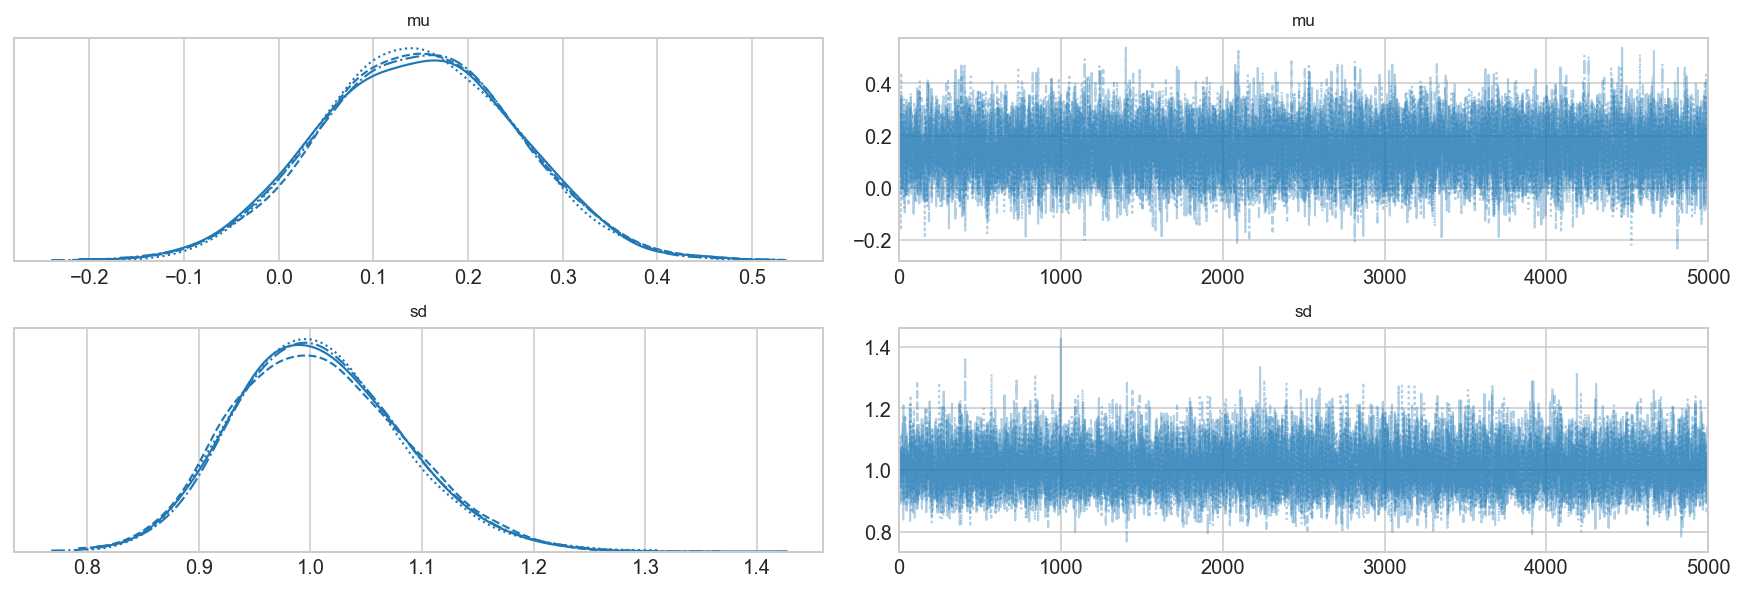

In [4]:
pm.traceplot(trace)
pass

In [5]:
trace['mu'].shape

(20000,)

This function will randomly draw 500 samples of parameters from the trace. Then, for each sample, it will draw 100 random numbers from a normal distribution specified by the values of mu and std in that sample. 

Where does the '100' come from? Same as the size of the observed data?

In [30]:
ppc = pm.sample_posterior_predictive(trace, samples=500, model=model)

/Applications/anaconda3/envs/stats/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:00<00:00, 1260.63it/s]


In [31]:
ppc['n'].shape  # num of rows = num of sampled parameters

(500, 100)

#### Check 1. Reproduce pattern in observed data
One common way to visualize is to look if the model can reproduce the patterns observed in the real data. For example, how close are the inferred means to the actual sample mean:

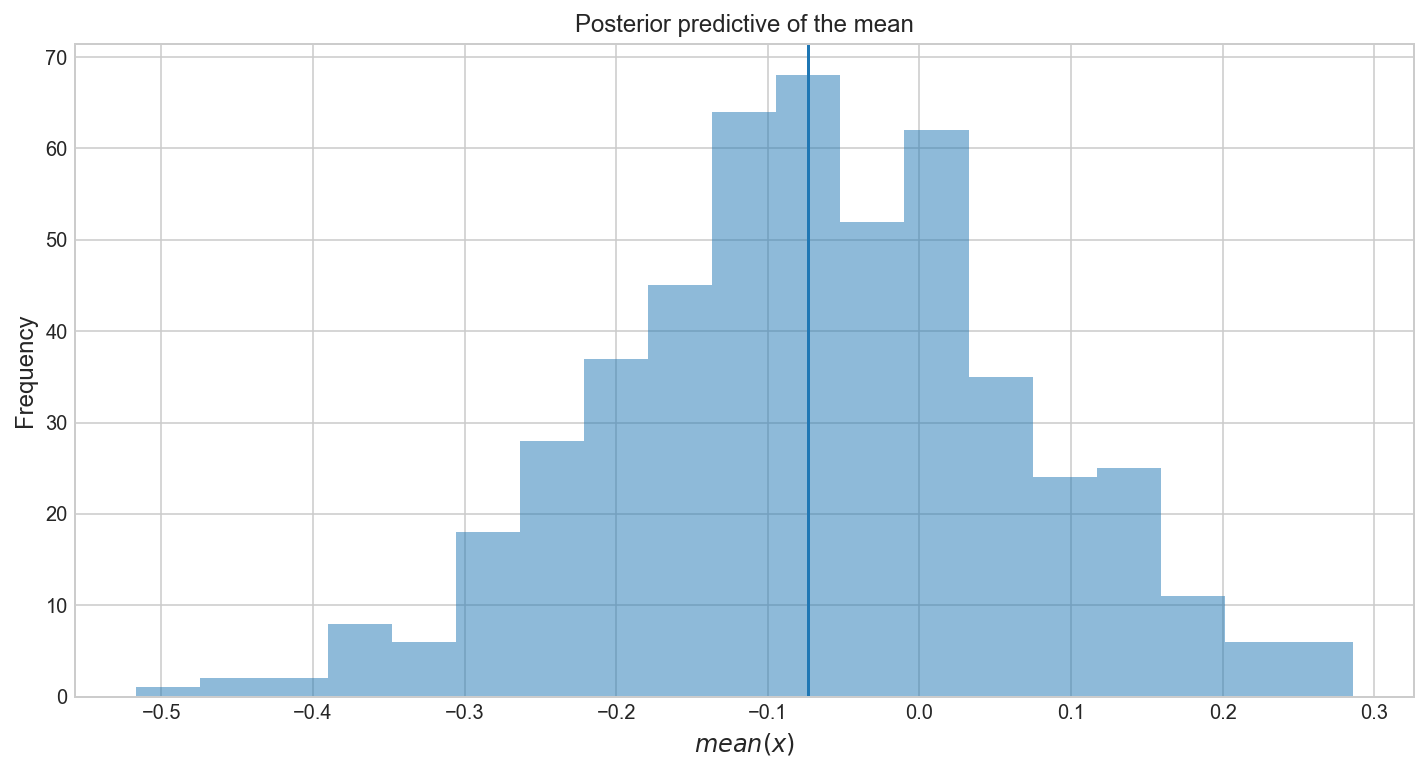

In [33]:
_, ax = plt.subplots(figsize=(12, 6))
ax.hist(ppc['n'].mean(axis=1), bins=19, alpha=0.5)
ax.axvline(data.mean())
ax.set(title='Posterior predictive of the mean', 
       xlabel='$mean(x)$', ylabel='Frequency')
pass

#### Check 2. Prediction

In [35]:
# training set
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

n = 4000
coeff = 1.

predictors = np.random.normal(size=n)
predictors_shared = shared(predictors)

outcomes = np.random.binomial(1, invlogit(coeff * predictors))

In [36]:
outcomes

array([1, 0, 1, ..., 0, 0, 1])

In [37]:
# test set
predictors_out_of_sample = np.random.normal(size=50)
outcomes_out_of_sample = np.random.binomial(1, invlogit(coeff*predictors_out_of_sample))

In [38]:
with pm.Model() as model:
    coeff = pm.Normal('coeff', mu=0, sigma=1)
    outcome = pm.Bernoulli('outcome', logit_p=coeff*predictors_shared, observed=outcomes)
    trace = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coeff]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [00:06<00:00, 3471.73draws/s]


In [39]:
# changing values here will also change values in the model
predictors_shared.set_value(predictors_out_of_sample)

In [40]:
# ppc now will use test set data and do predictions
ppc = pm.sample_posterior_predictive(trace, samples=100, model=model)

/Applications/anaconda3/envs/stats/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 100/100 [00:00<00:00, 712.85it/s]


#### Visualize mean predicted values
Note that these are uncertainty caused by MCMC estimation, and not from the underlying model. If we had taken more samples in sample_posterior_predictive, the error bars would get smaller quite quickly.

I cant work out why `beta` can have an interval for each predictor point. Beta is of shape (50,). Neither can I work out the math for why posterior distribution is beta, given normal prior and bernouli likelihood.

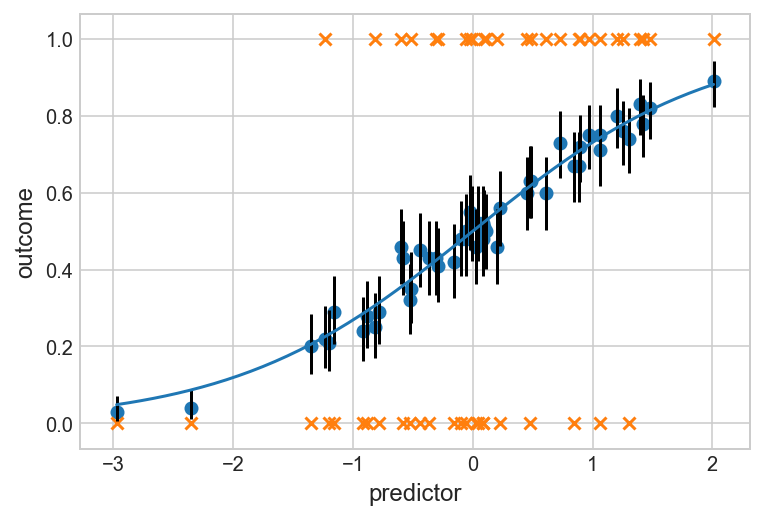

In [54]:
_, ax = plt.subplots(1, 1)

beta = st.beta(ppc['outcome'].sum(axis=0), (1-ppc['outcome']).sum(axis=0))

# estimated probs
ax.scatter(x=predictors_out_of_sample, y=beta.mean())

# error bars on the estimate
plt.vlines(predictors_out_of_sample, *beta.interval(0.95))

# actual outcomes
ax.scatter(x=predictors_out_of_sample, 
           y=outcomes_out_of_sample, marker='x')

# true probs
x = np.linspace(predictors_out_of_sample.min(), predictors_out_of_sample.max())
ax.plot(x, invlogit(x), linestyle='-')

ax.set_xlabel('predictor')
ax.set_ylabel('outcome');